In [30]:
import pandas as pd
import requests as rq
import matplotlib.pyplot as plt
import os
import sys
from dotenv import load_dotenv

In [31]:
def load_env():
    load_dotenv()
    return os.getenv('DATE_BEGIN', ''), os.getenv('DATE_END', ''), os.getenv('API_URL', '')

In [32]:
def create_charts_folder():
    current_dir = os.getcwd() 
    charts_folder = os.path.join(current_dir, 'charts')

    if not os.path.exists(charts_folder):
        os.makedirs(charts_folder)

In [33]:
def visits_grouped():
    DATE_BEGIN, DATE_END, API_URL = load_env()
    vis = rq.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
    visits = pd.DataFrame.from_records(vis.json())
    visits = visits.drop_duplicates()
    visits['datetime'] = pd.to_datetime(visits['datetime'])
    mask = visits['platform'].str.contains('bot')
    visits = visits[~mask]
    max_visits = visits.loc[visits.groupby('visit_id')['datetime'].idxmax()]
    max_visits['datetime'] = max_visits['datetime'].dt.date
    mask = max_visits['platform'].str.contains('bot')
    max_visits = max_visits[~mask]  
    gr_vis = max_visits.groupby(['datetime', 'platform']).agg({'visit_id': 'count'}).head(1000)
    
    return gr_vis.head(1000)


In [34]:
def registrations_grouped():
    DATE_BEGIN, DATE_END, API_URL = load_env()
    rgs = rq.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
    regs= pd.DataFrame.from_records(rgs.json())
    regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date
    gr_regs= regs.groupby(['datetime', 'platform']).agg({'user_id': 'count'})
    return gr_regs.head(1000)


In [35]:
def conversion():
    gr_vis = visits_grouped()
    gr_regs = registrations_grouped()
    rv_merged = pd.merge(gr_vis, gr_regs, on=['datetime', 'platform'])
    rv_merged = rv_merged.rename(columns={'datetime': 'date_group', 'visit_id': 'visits', 'user_id': 'registrations'})
    rv_merged['conversion'] = (rv_merged['registrations'] / rv_merged['visits']) * 100
    dfconv = rv_merged.reset_index()
    dfconv.to_json('./conversion.json')
    return dfconv.head(1000)


In [36]:
def ads_upload_merge():
    ads = pd.read_csv('ads.csv')
    ads = ads.rename(columns={'date': 'datetime'})
    ads['datetime'] = pd.to_datetime(ads['datetime']).dt.date
    ads_new = ads.loc[:, ['datetime', 'cost', 'utm_campaign']]
    dfconv = conversion()
    rv_merged1 = pd.merge(dfconv, ads_new, on=['datetime'], how='left')
    rv_merged1['cost'] = rv_merged1['cost'].fillna(0)
    rv_merged1['utm_campaign'] = rv_merged1['utm_campaign'].fillna('none')
    rv_merged1 = rv_merged1.rename(columns={'datetime': 'date_group', 'utm_campaign': 'campaign'})
    ads_merged = rv_merged1.loc[:, ['date_group', 'visits', 'registrations', 'cost', 'campaign']]
    ads_merged.to_json('./ads.json')
    return ads_merged.head(1000)


In [37]:
def itog_visits():
    # Итоговые визиты
    rv_merged1 = ads_upload_merge()
    rv_merged1_agg = rv_merged1.groupby('date_group')['visits'].sum().reset_index()
    plt.figure(figsize=(40, 30))
    plt.bar(rv_merged1_agg['date_group'], rv_merged1_agg['visits'])
    for i in range(len(rv_merged1_agg['date_group'])):
        plt.text(rv_merged1_agg['date_group'][i], rv_merged1_agg['visits'][i], str(rv_merged1_agg['visits'][i]), ha='center')
    plt.xlabel('date_group')
    plt.ylabel('Visits')
    plt.title('Total visits')
    plt.xticks(rotation=45)
    plt.gca().set_xticks(rv_merged1_agg['date_group']) 
    plt.gca().xaxis.set_tick_params(labelsize=8)
    plt.savefig("charts/Total_Visits.png")
    

In [38]:
def itog_visits_by_platform():
    #Итоговые визиты с разбивкой по платформам: web, android, ios, bot
    gr_vis = conversion() 
    gr_vis['datetime'] = pd.to_datetime(gr_vis['datetime'])

    fig, axs = plt.subplots(1, 1, figsize=(20, 12))

    df_pivot_visit = gr_vis.pivot_table(values='visits', index='datetime', columns='platform', aggfunc='sum') 
    ax = df_pivot_visit.plot(kind='bar', stacked=True, ax=axs) 
    ax.set_xlabel('date_group') 
    ax.set_ylabel('visits') 
    ax.set_title('Visits by platform(Staked)') 
    ax.legend(title='platform') 
    ax.yaxis.grid(True)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') 
    ax.xaxis.set_major_locator(plt.MaxNLocator(30))

    plt.tight_layout()
    plt.savefig("charts/Visits_By_Platform.png")


In [39]:
def itog_registrations():
    # Итоговые регистрации
    gr_regs = registrations_grouped()
    group_plt = gr_regs.groupby('datetime')['user_id'].sum().reset_index()
    plt.figure(figsize=(40, 30))
    plt.bar(group_plt['datetime'], group_plt['user_id'])
    for i in range(len(group_plt['datetime'])):
        plt.text(group_plt['datetime'][i], group_plt['user_id'][i], str(group_plt['user_id'][i]), ha='center')
    plt.xlabel('date_group')
    plt.ylabel('registrations')
    plt.title('Total weekly registrations')
    plt.xticks(rotation=45)
    plt.gca().set_xticks(group_plt['datetime']) 
    plt.gca().xaxis.set_tick_params(labelsize=8)
    plt.savefig("charts/Total_Weekly_Registrations.png")

In [40]:
def itog_registrations_by_paltform():
    gr_vis = conversion() 
    gr_vis['datetime'] = pd.to_datetime(gr_vis['datetime'])

    fig, axs = plt.subplots(1, 1, figsize=(20, 12))

    df_pivot_visit = gr_vis.pivot_table(values='registrations', index='datetime', columns='platform', aggfunc='sum') 
    ax = df_pivot_visit.plot(kind='bar', stacked=True, ax=axs) 
    ax.set_xlabel('date_group') 
    ax.set_ylabel('registrations') 
    ax.set_title('Registrations by platform(Staked)') 
    ax.legend(title='platform') 
    ax.yaxis.grid(True)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') 
    ax.xaxis.set_major_locator(plt.MaxNLocator(30))

    plt.tight_layout() 
    plt.savefig("charts/Weekly_Registrations_By_Platform.png")


In [41]:
def registrations_by_type():
    # Итоговые регистрации с разбивкой по типу регистрации
    DATE_BEGIN, DATE_END, API_URL = load_env()
    rgs = rq.get(f'{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}')
    r = rgs.json()
    reg = pd.DataFrame.from_dict(r)
    regs = reg.sort_values('datetime').copy()
    regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date 
    gr_regs_type = regs.groupby(['datetime', 'registration_type']).agg({'user_id': 'count'}) 
    fig, axs = plt.subplots(1, 1, figsize=(20, 12))
    df_pivot_visit = gr_regs_type.pivot_table(values='user_id', index='datetime', columns='registration_type', aggfunc='sum') 
    ax = df_pivot_visit.plot(kind='bar', stacked=True, ax=axs) 
    ax.set_xlabel('date_group') 
    ax.set_ylabel('registrations') 
    ax.set_title('Registrations by type(Staked)') 
    ax.legend(title='platform') 
    ax.yaxis.grid(True)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') 
    ax.xaxis.set_major_locator(plt.MaxNLocator(30))

    plt.tight_layout() 
    plt.savefig("charts/Weekly_Registrations_By_Registration_Type.png")


In [42]:
def registrations_by_type_pie():
    # Итоговые регистрации с разбивкой по типу регистрации
    DATE_BEGIN, DATE_END, API_URL = load_env()
    rgs = rq.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
    regs= pd.DataFrame.from_records(rgs.json())
    regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date
    gr_regs_type = regs.groupby(['datetime', 'registration_type']).agg({'user_id': 'count'})
    df_pivot_regs_type = gr_regs_type.pivot_table(values='user_id', index='datetime', columns='registration_type', aggfunc='sum')
    # Итоговые регистрации с разбивкой по типу регистрации - pie chart
    plt.subplot(1, 2, 1)  # Подграфик 1
    plt.pie(df_pivot_regs_type.sum(), labels=df_pivot_regs_type.columns, autopct='%1.1f%%')
    plt.title('Registration by Type')

    gr_regs_platform = regs.groupby(['datetime', 'platform']).agg({'user_id': 'count'})
    df_pivot_regs_platform = gr_regs_platform.pivot_table(values='user_id', index='datetime', columns='platform', aggfunc='sum')
    # Итоговые регистрации с разбивкой по платформе - pie chart
    plt.subplot(1, 2, 2)  # Подграфик 2
    plt.pie(df_pivot_regs_platform.sum(), labels=df_pivot_regs_platform.columns, autopct='%1.1f%%')
    plt.title('Registration by Platform')

    plt.tight_layout() 
    plt.savefig("charts/Registrations_By_Platform_And_Type.png")

In [43]:
def overall_conversion():
    # Итоговые конверсии
    dfconv = conversion()
    conv_plot = dfconv.groupby('datetime')['conversion'].mean().reset_index()
    plt.figure(figsize=(20, 14))
    plt.plot(conv_plot['datetime'], conv_plot['conversion'], label='Overall Conversion')
    for i in range(len(conv_plot)):
        annotation = str(round(conv_plot['conversion'][i])) + ' %'
        plt.annotate(annotation, (conv_plot['datetime'][i], conv_plot['conversion'][i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.title('Overall conversion')
    plt.xticks(rotation=45)
    plt.legend(title='Общая конверсия')
    plt.grid(True)
    plt.savefig("charts/Overall_Conversion.png")
    

In [44]:
def conversion_by_platform():
    dfconv = conversion()
    # Конверсия по каждой платформе
    plt.subplots(figsize=(20, 20))
    plt.subplot(3, 1, 1)
    plt.plot(dfconv[dfconv['platform'] == 'android']['datetime'], dfconv[dfconv['platform'] == 'android']['conversion'])
    for i in range(len(dfconv)):
        annotation = str(round(dfconv['conversion'][i])) + '%'
        plt.annotate(annotation, (dfconv['datetime'][i], dfconv['conversion'][i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.title('Conversion Android')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(dfconv[dfconv['platform'] == 'ios']['datetime'], dfconv[dfconv['platform'] == 'ios']['conversion'])
    for i in range(len(dfconv)):
        annotation = str(round(dfconv['conversion'][i])) + '%'
        plt.annotate(annotation, (dfconv['datetime'][i], dfconv['conversion'][i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.title('Conversion iOS')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(dfconv[dfconv['platform'] == 'web']['datetime'], dfconv[dfconv['platform'] == 'web']['conversion'])
    for i in range(len(dfconv)):
        annotation = str(round(dfconv['conversion'][i])) + '%'
        plt.annotate(annotation, (dfconv['datetime'][i], dfconv['conversion'][i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.title('Conversion Web')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("charts/Conversion_By_Platform.png")

In [45]:
def ads_cost():
    # Стоимости реклам
    rv_merged1 = ads_upload_merge()
    cost_plot = rv_merged1.groupby('date_group')['cost'].mean().reset_index() 
    cost_plot['cost'] = cost_plot['cost'].astype(int)
    plt.figure(figsize=(15, 10)) 
    plt.plot(cost_plot['date_group'], cost_plot['cost'], label='Overall Conversion')

    for i in range(len(cost_plot)):
        annotation = str(cost_plot['cost'][i]) + ' RUB'
        plt.annotate(annotation, (cost_plot['date_group'][i], cost_plot['cost'][i]), textcoords="offset points", xytext=(0,6), ha='center')

    plt.xlabel('Date')
    plt.ylabel('Cost (RUB)')
    plt.title('Aggregated Ad Campaign Costs (by day) ')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig("charts/Aggregated_Ad_Campaign_Costs.png")

In [46]:
def visreq_colored():
    #Визиты и регистрации с выделением рекламных кампаний
    rv_merged1 = ads_upload_merge()
    rv_merged1 = rv_merged1.loc[rv_merged1['campaign'] != 'none']
    painted_visits = rv_merged1.groupby(['date_group', 'campaign']).agg({'visits': 'sum'})
    painted_registrations = rv_merged1.groupby(['date_group', 'campaign']).agg({'registrations': 'sum'})


    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))

    for campaign in rv_merged1['campaign'].unique():
        campaign_data_visits = painted_visits.loc[painted_visits.index.get_level_values('campaign') == campaign]
        campaign_data_registrations = painted_registrations.loc[painted_registrations.index.get_level_values('campaign') == campaign]
        ax1.plot(campaign_data_visits.index.get_level_values('date_group'), campaign_data_visits['visits'], label=campaign)
        ax1.fill_between(campaign_data_visits.index.get_level_values('date_group'), 0, campaign_data_visits['visits'], alpha=0.2)
        ax2.plot(campaign_data_registrations.index.get_level_values('date_group'), campaign_data_registrations['registrations'], label=campaign)
        ax2.fill_between(campaign_data_registrations.index.get_level_values('date_group'), 0, campaign_data_registrations['registrations'], alpha=0.2)

    ax1.set_ylabel('Unique Visits')
    ax1.set_title('Visits during marketing active days')
    ax1.grid(True)
    ax1.legend()

    ax2.set_ylabel('Unique registrations')
    ax2.set_title('Registrations during marketing active days')
    ax2.grid(True)
    ax2.legend()

    plt.savefig("charts/Visits_and_Registrations_Colored.png")


In [47]:
def first_half():
    load_env()
    create_charts_folder()
    visits_grouped()
    registrations_grouped()
    conversion()
    ads_upload_merge()
    ads_cost()
    

    

In [48]:
def second_half():
    visreq_colored()
    conversion_by_platform()
    overall_conversion() 
    registrations_by_type_pie()
    registrations_by_type()
    itog_registrations_by_paltform()
    itog_registrations()
    itog_visits_by_platform()
    itog_visits()

In [49]:
def run_all():
    first_half()
    second_half()
    

C:\Users\cah9_\AppData\Local\Temp\ipykernel_9036\4061355964.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
C:\Users\cah9_\AppData\Local\Temp\ipykernel_9036\3886912053.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)  # Подграфик 1


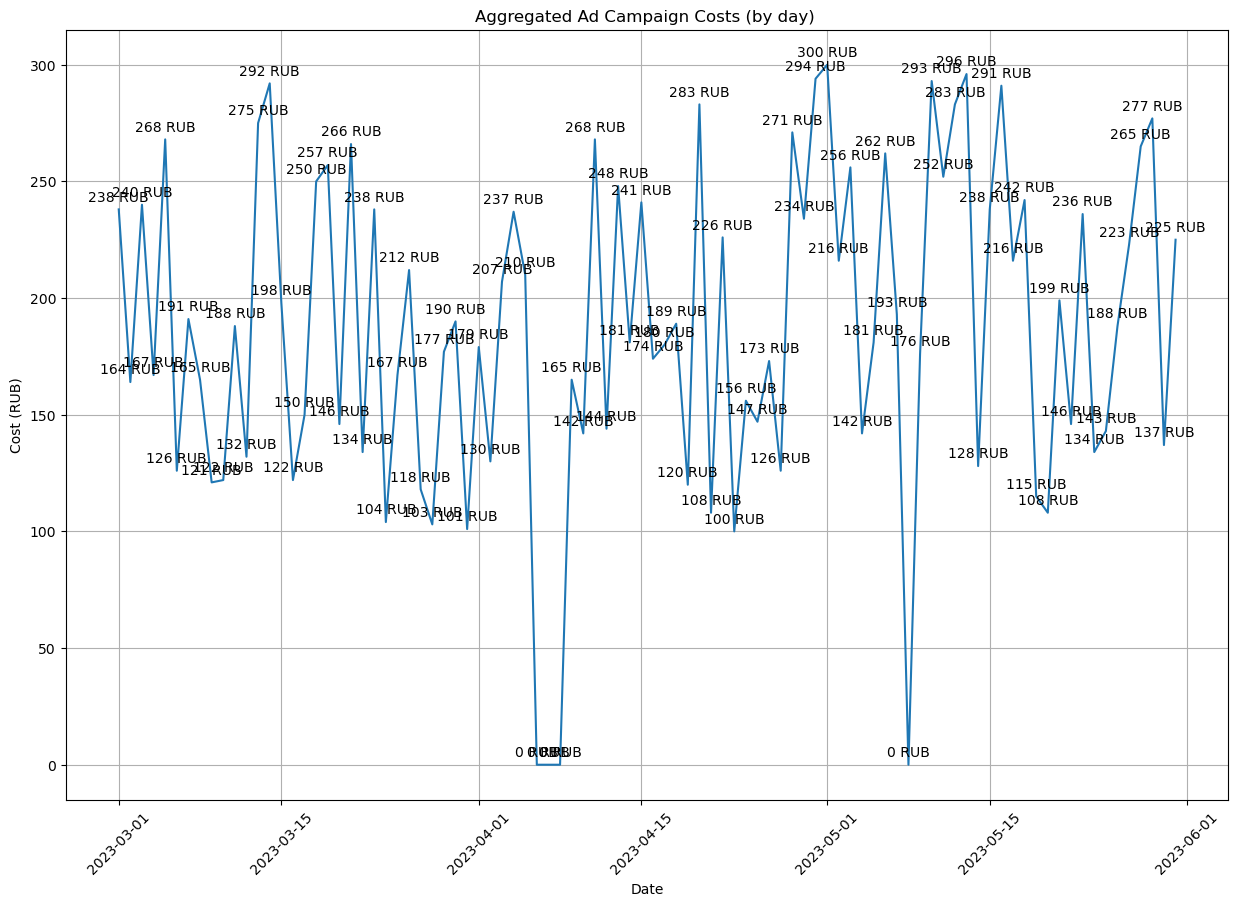

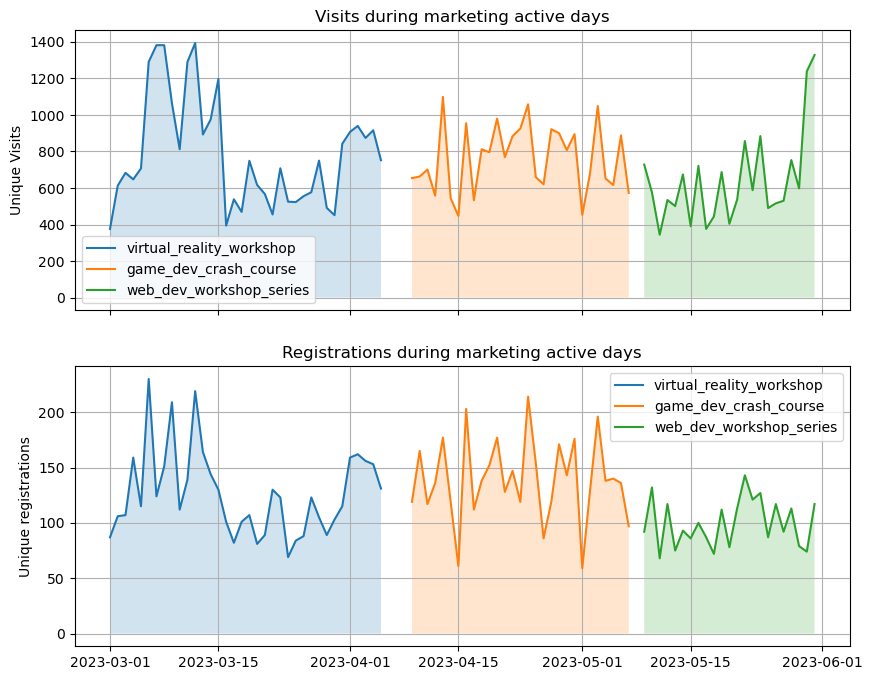

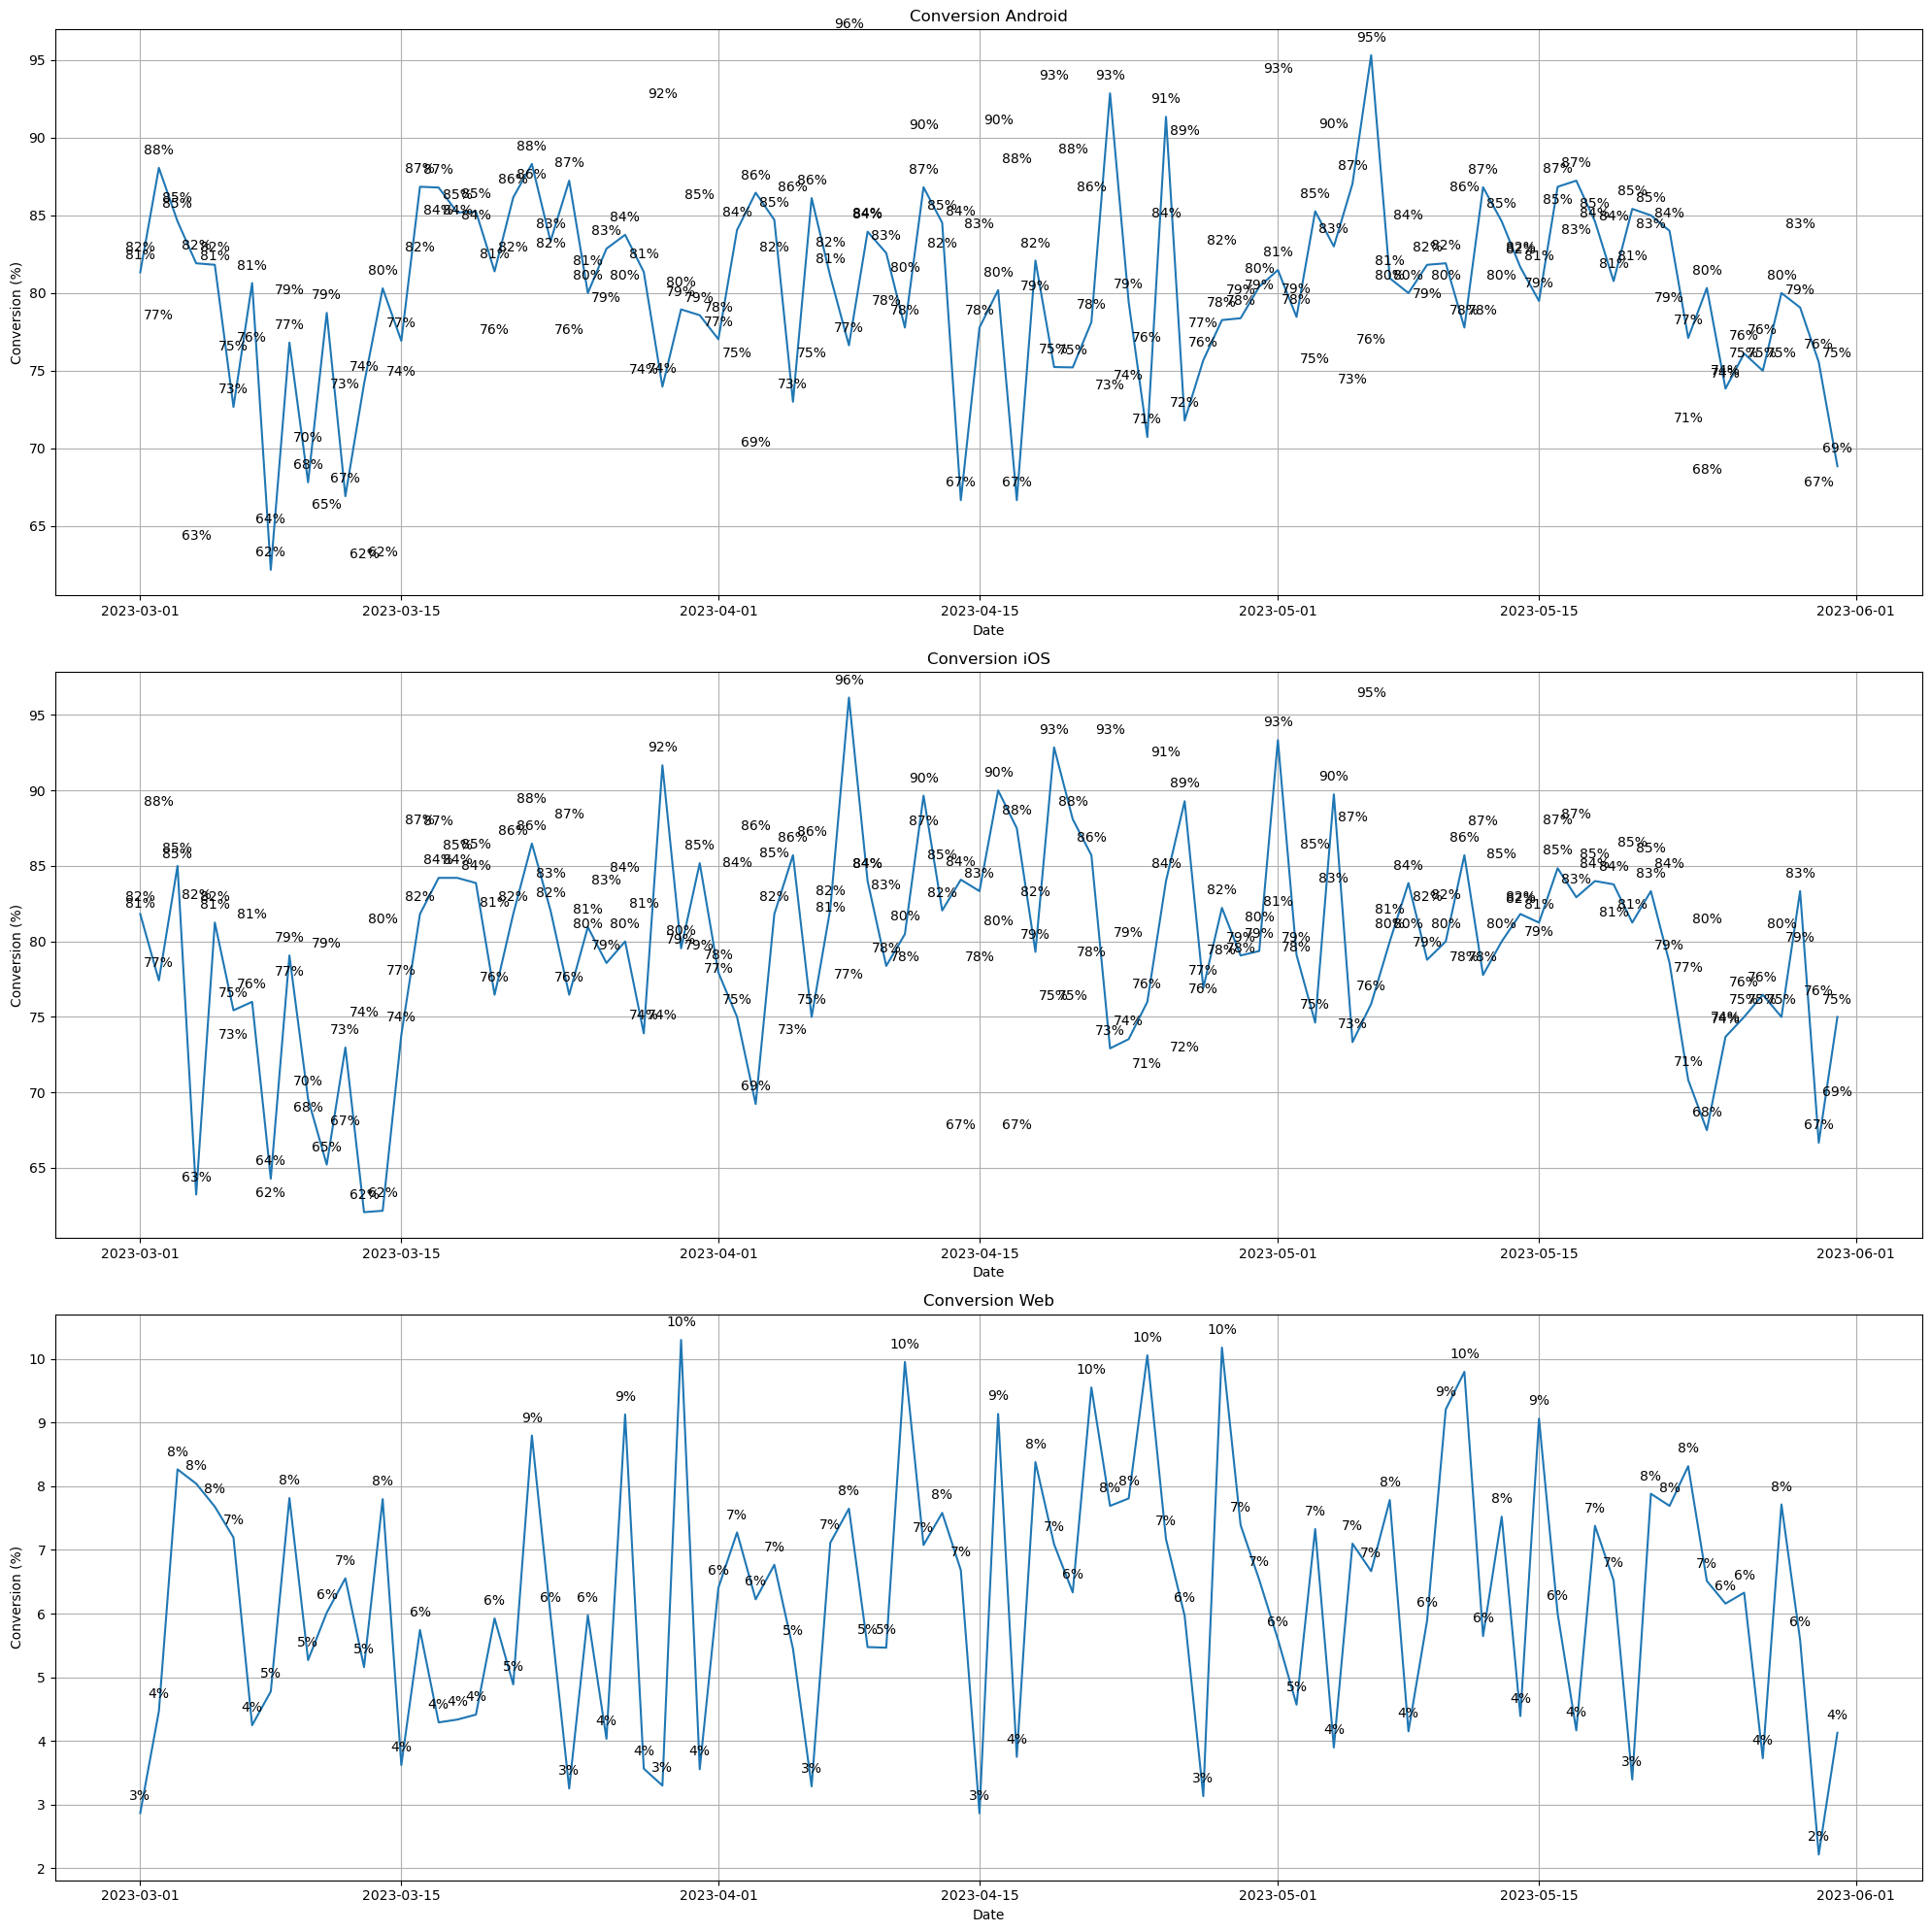

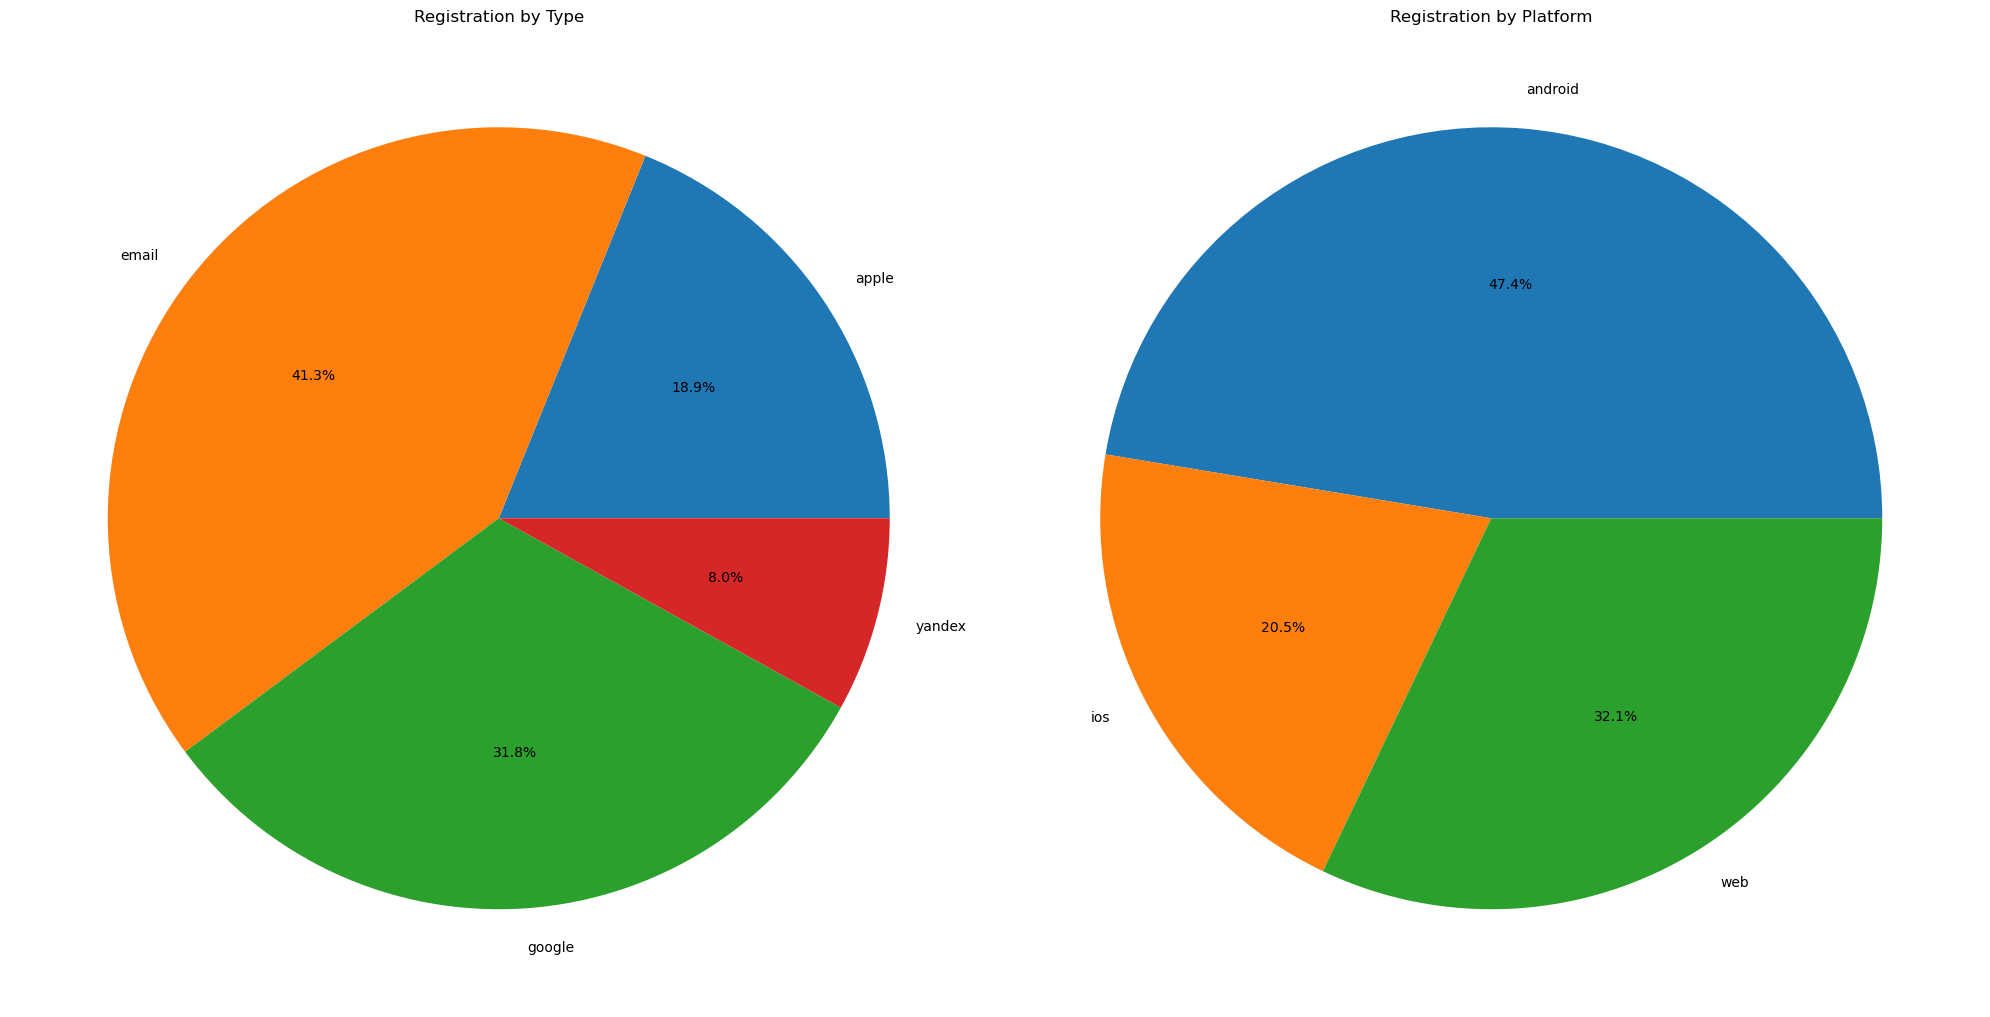

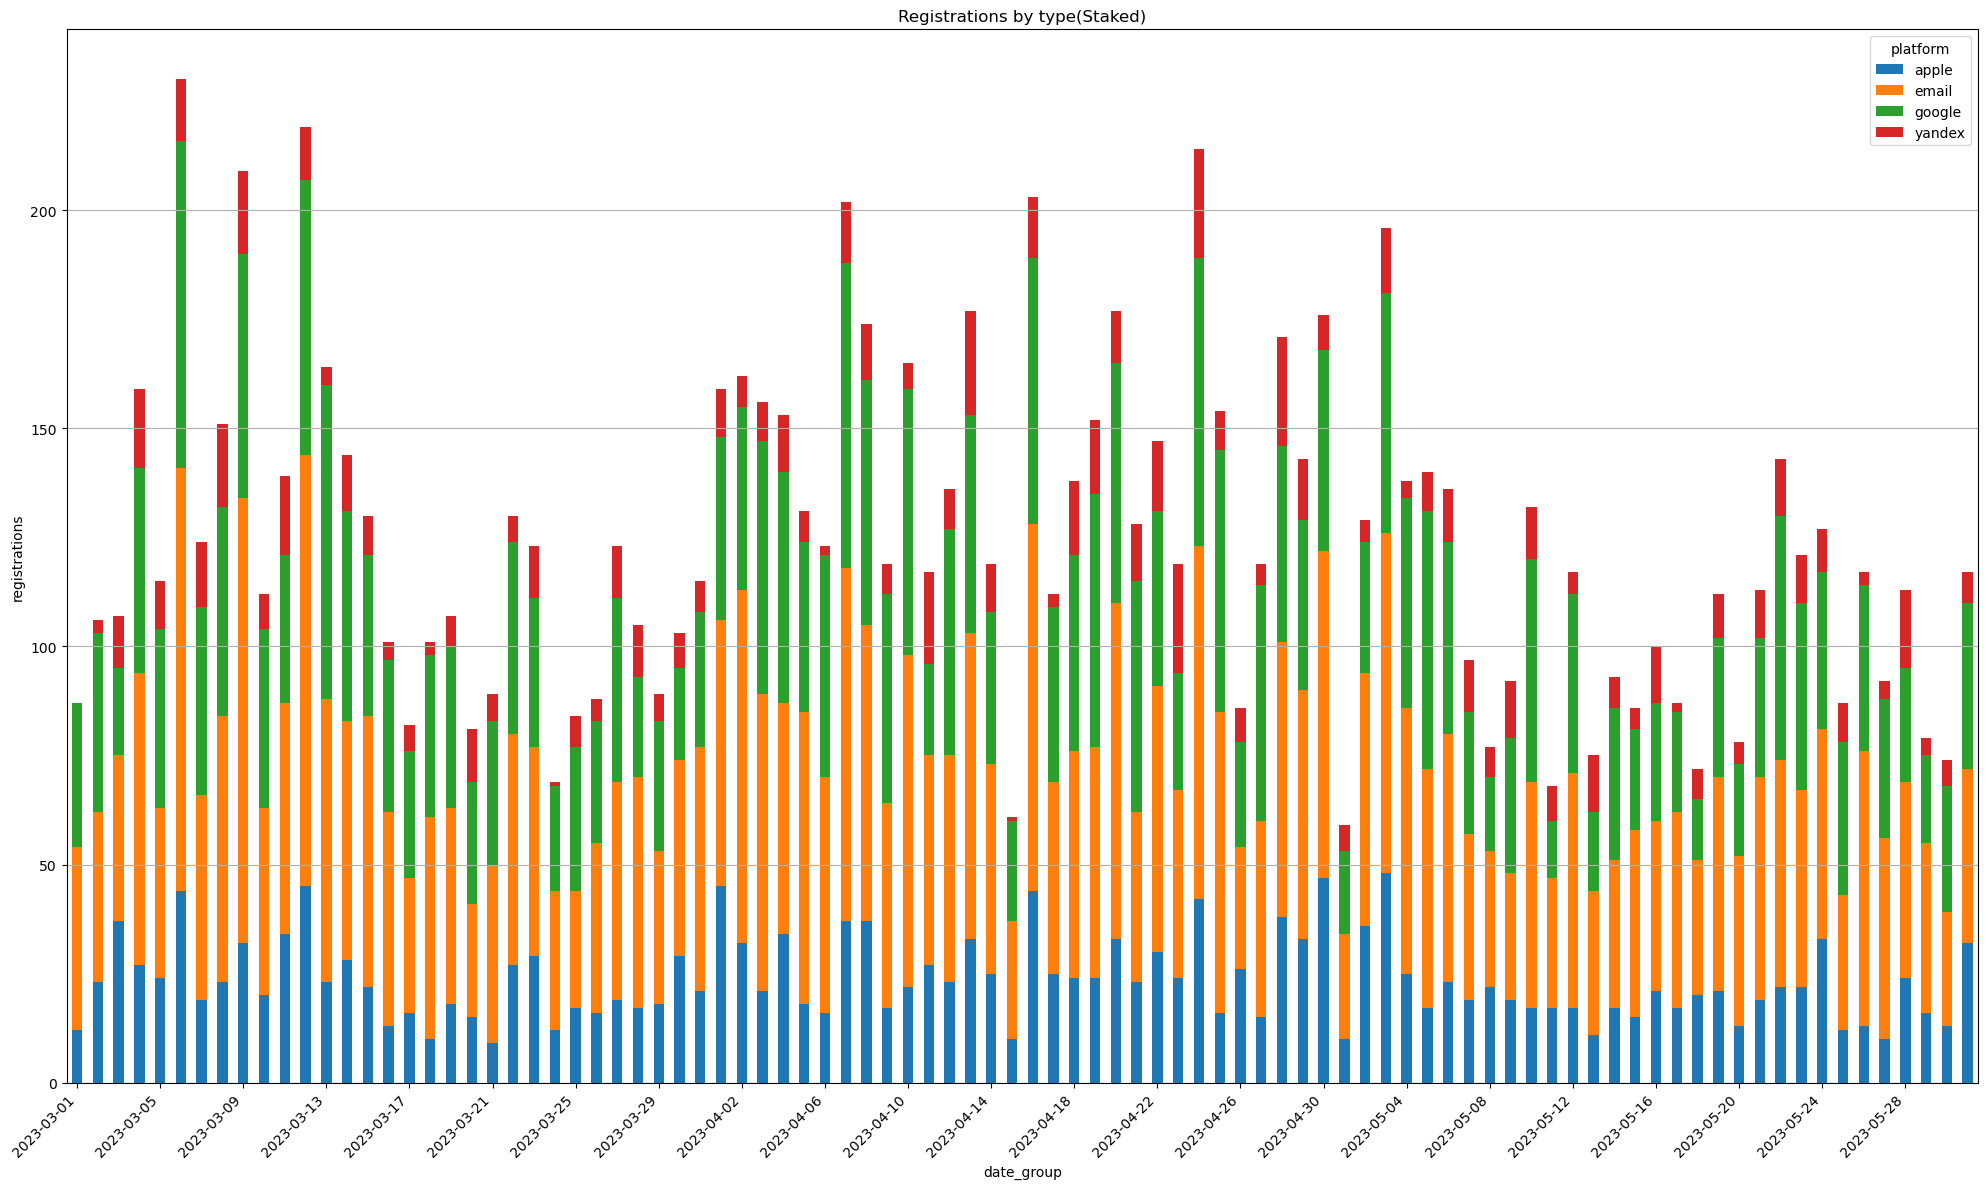

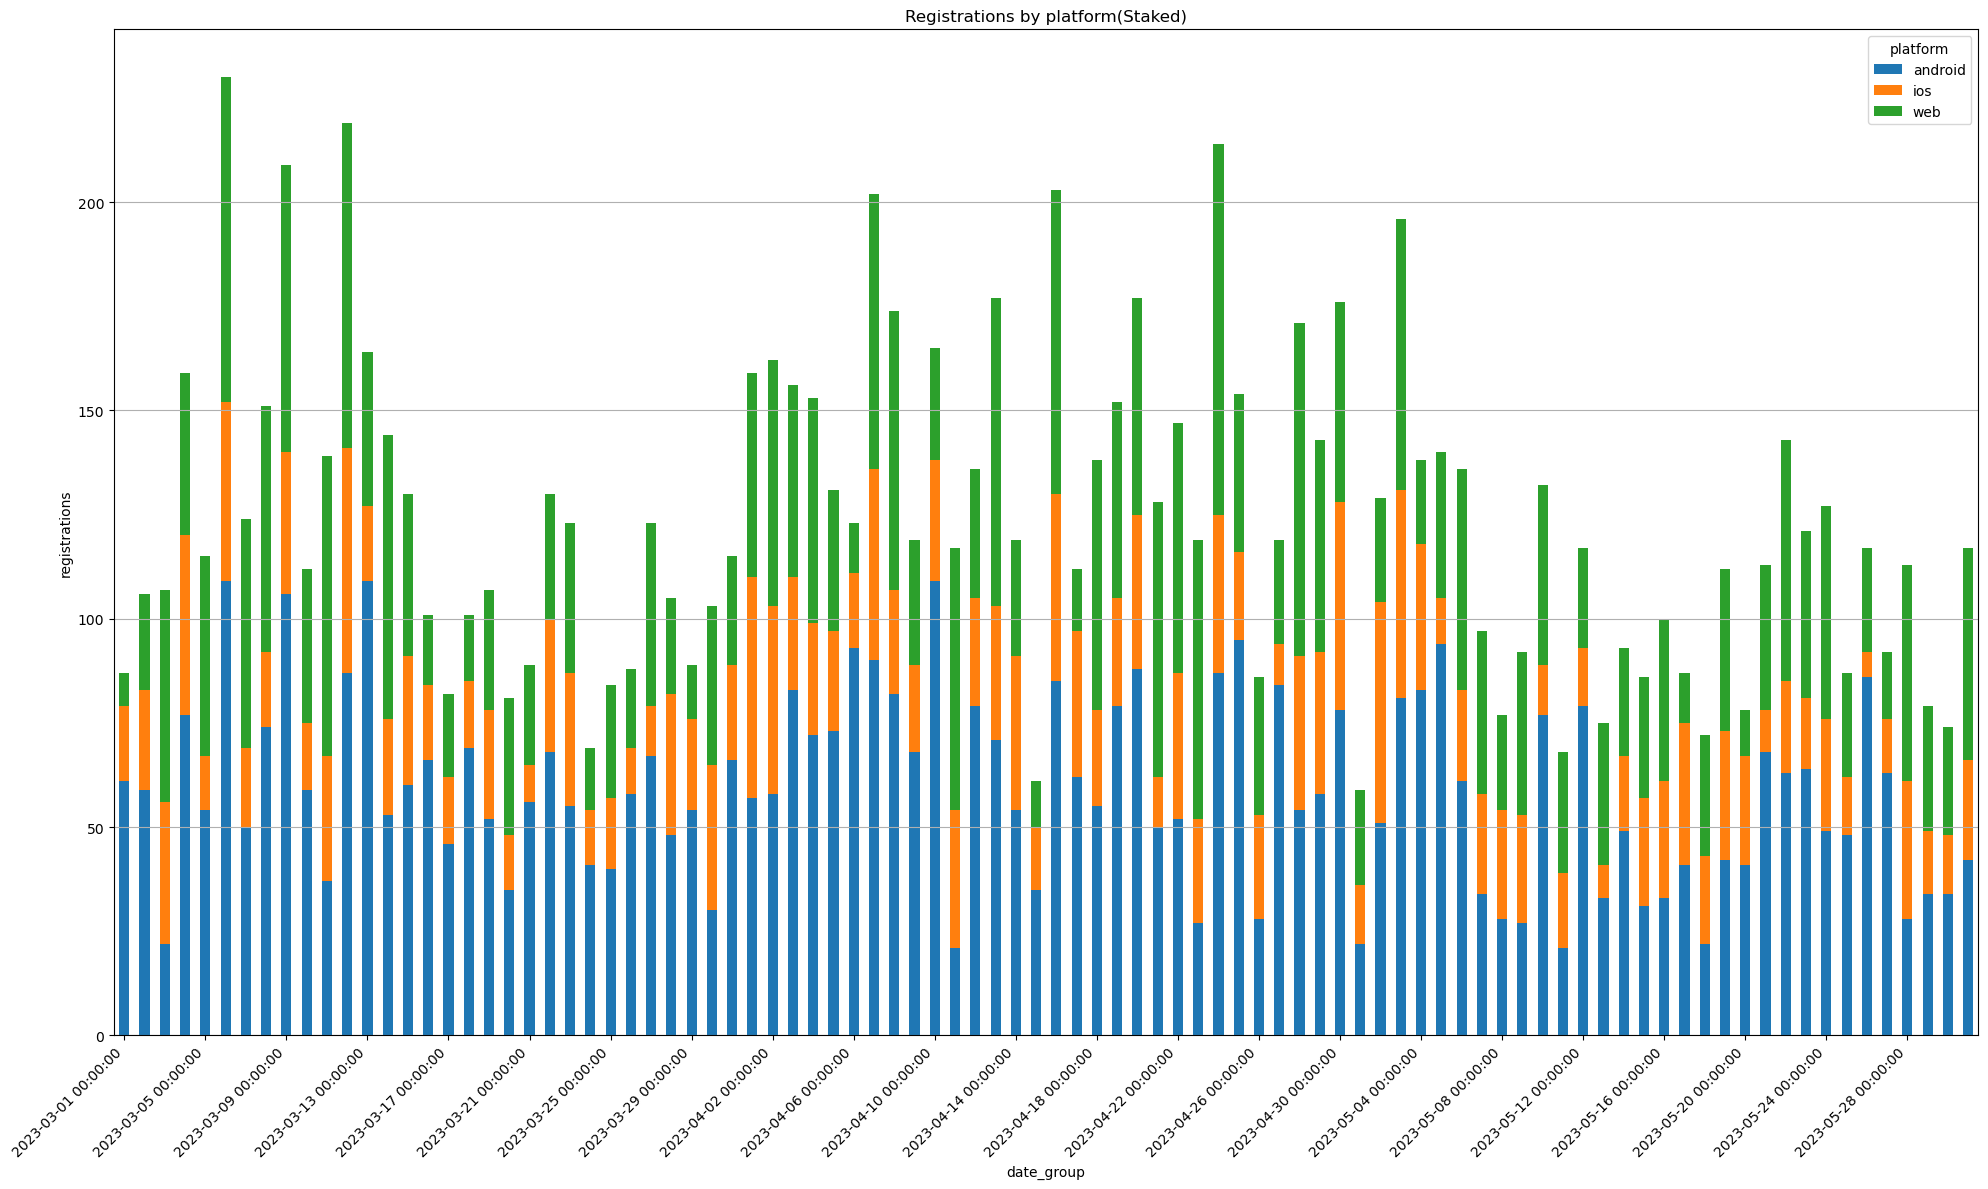

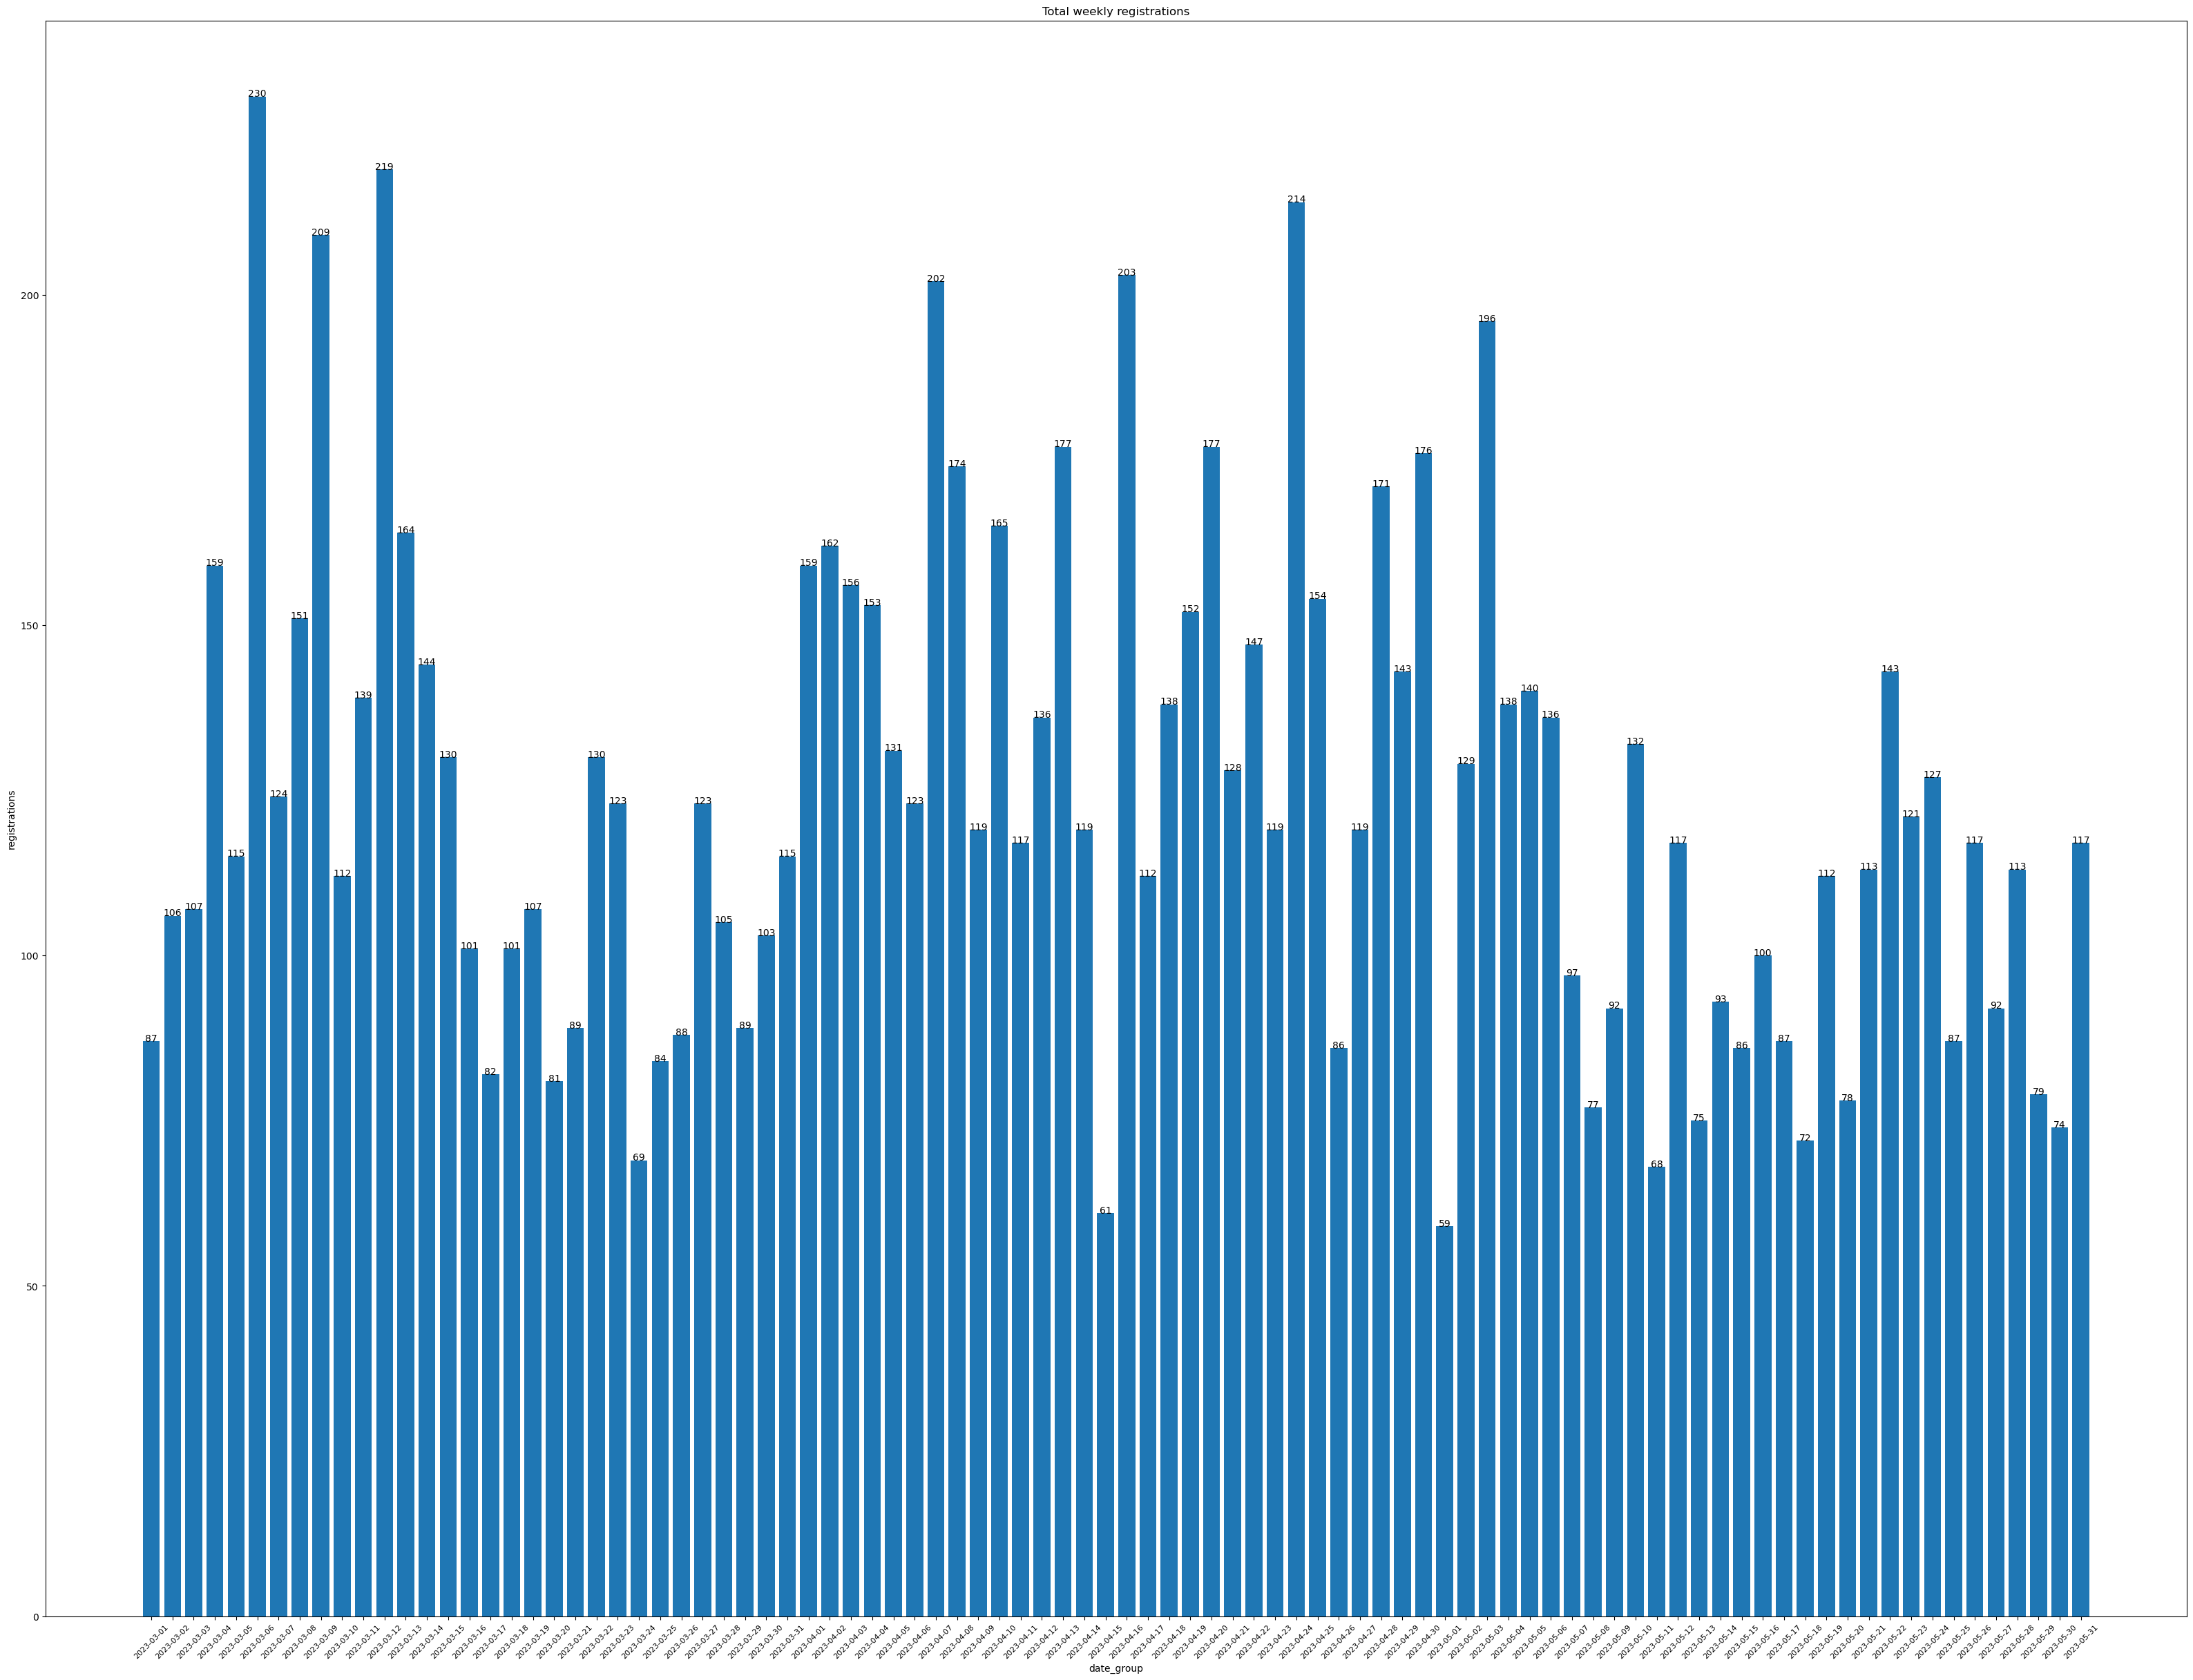

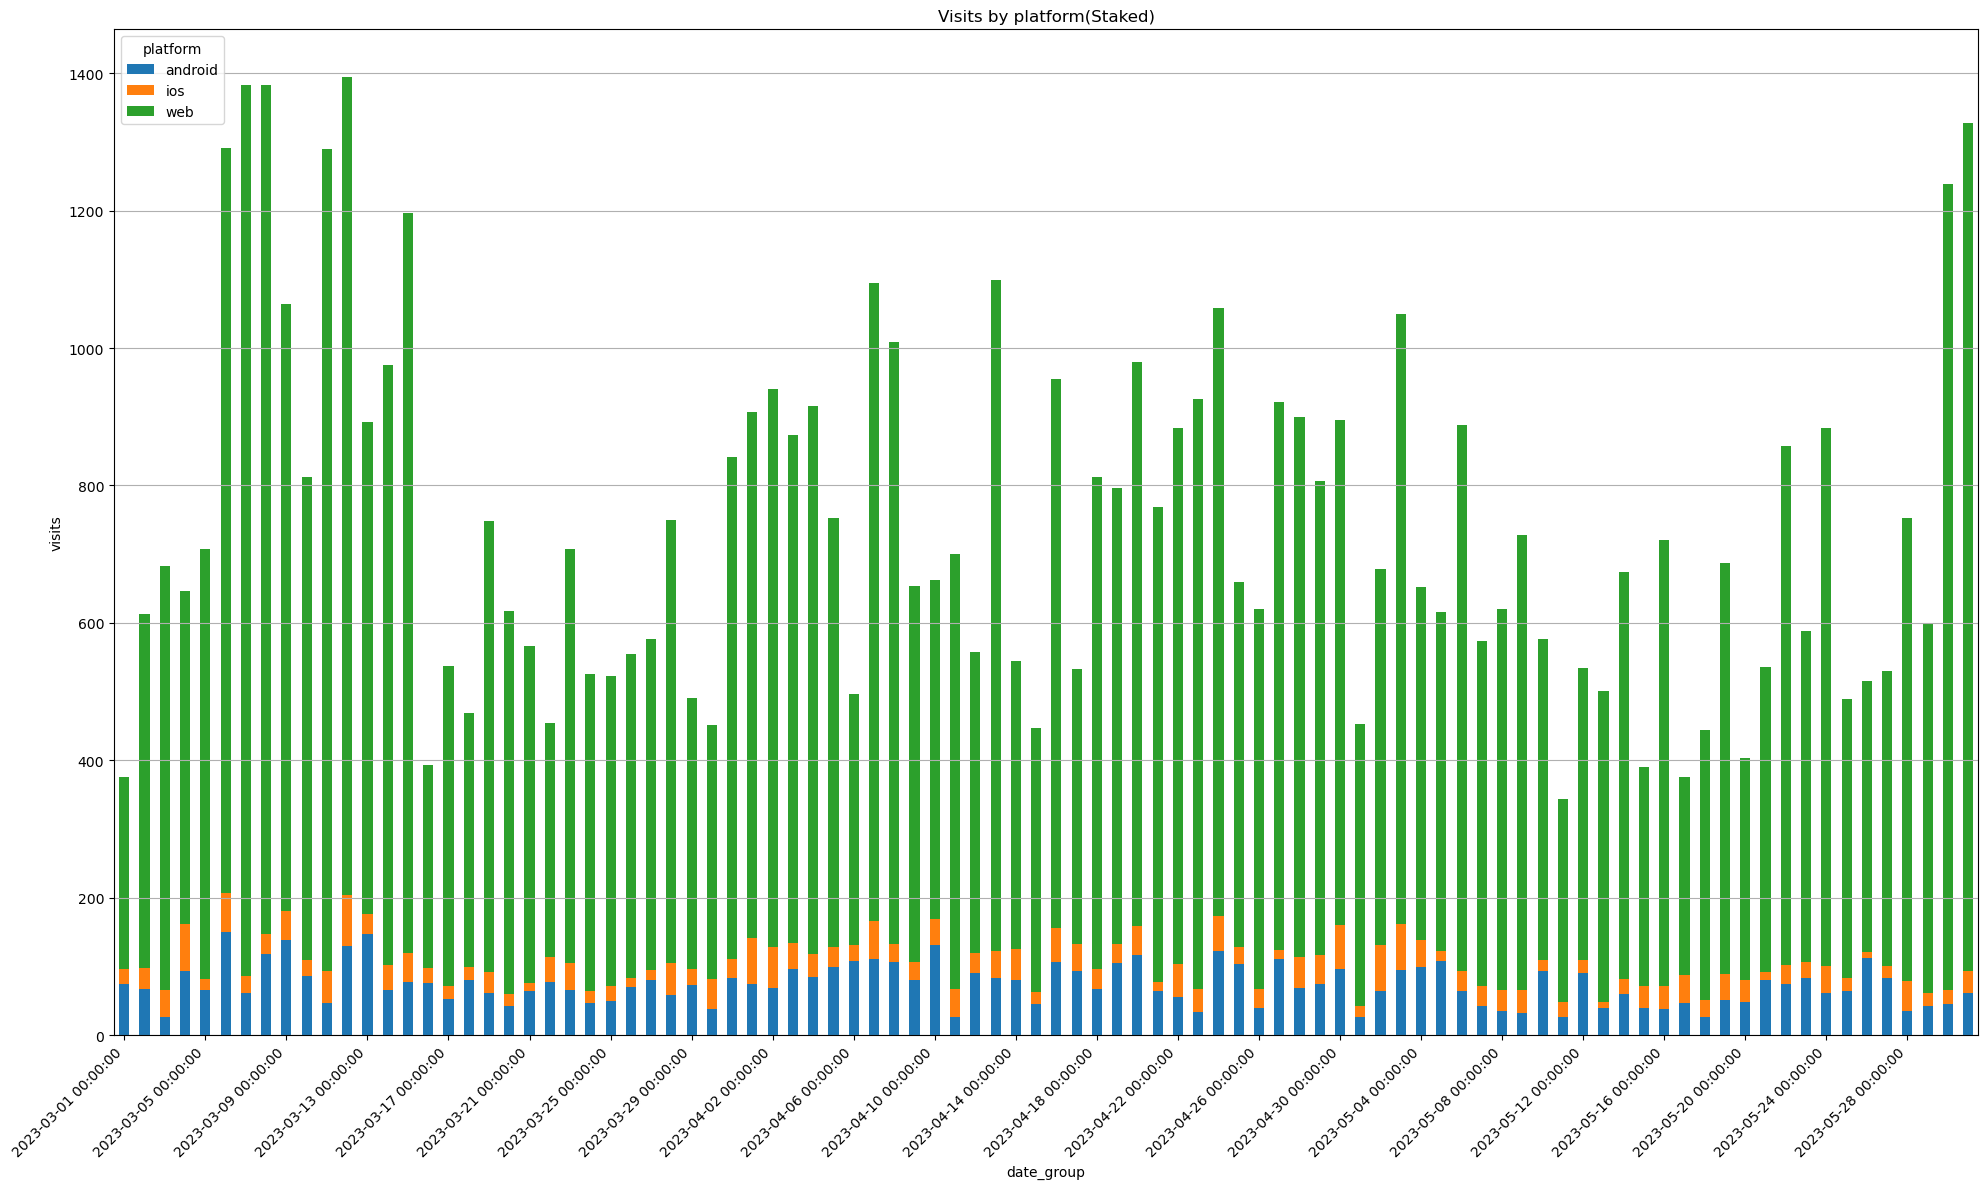

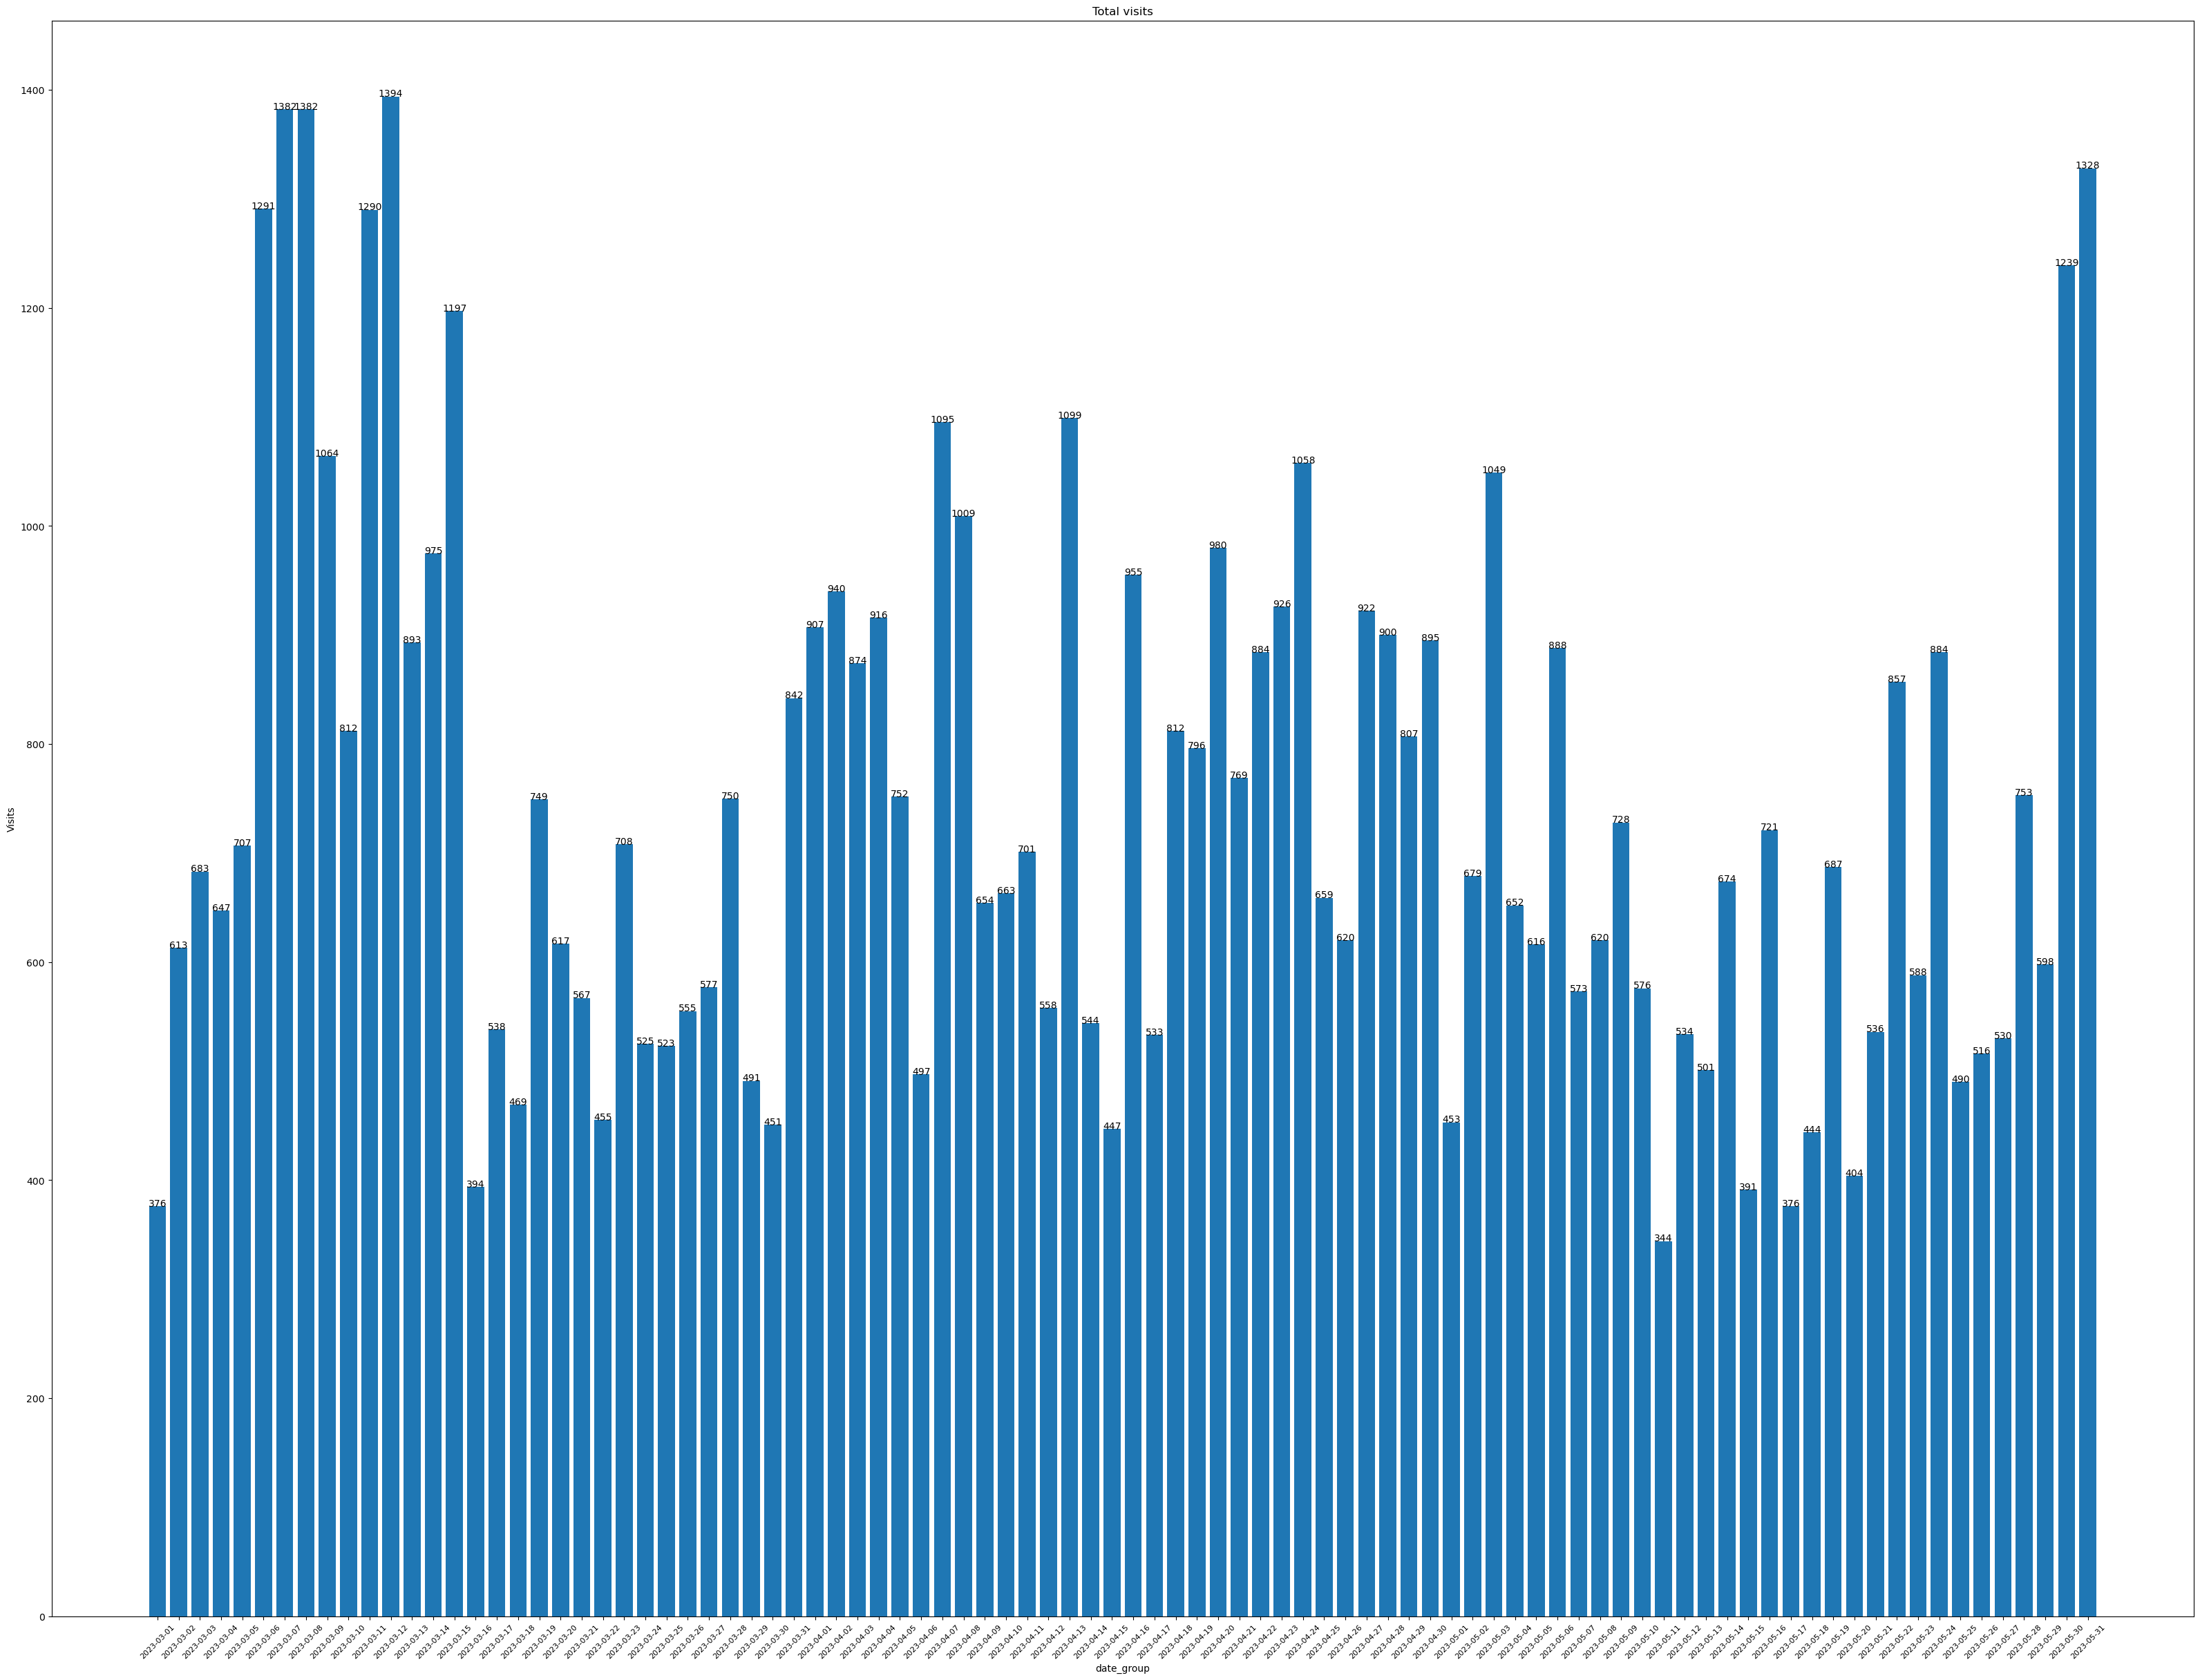

In [50]:
run_all()

In [ ]:
if __name__ == "__main__":
    run_all()

Variable                         Type        Data/Info
------------------------------------------------------
ads_cost                         function    <function ads_cost at 0x0000023E9A0932E0>
ads_upload_merge                 function    <function ads_upload_merge at 0x0000023EA54FDA80>
conversion                       function    <function conversion at 0x0000023EB5EBD8A0>
conversion_by_platform           function    <function conversion_by_p<...>rm at 0x0000023EA33E87C0>
create_charts_folder             function    <function create_charts_f<...>er at 0x0000023EA5502160>
first_half                       function    <function first_half at 0x0000023EA50EFCE0>
itog_registrations               function    <function itog_registrati<...>ns at 0x0000023EA44AE3E0>
itog_registrations_by_paltform   function    <function itog_registrati<...>rm at 0x0000023EA50EF6A0>
itog_visits                      function    <function itog_visits at 0x0000023EA50ED4E0>
itog_visits_by_platform          fun